In [1]:
import jax
import jax.numpy as jnp
from jax import random
key = random.PRNGKey(0)

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from src.nSigs import nSig 
from src.utils import LogNormal_weights, Gaussian_weights, Weibull_weights, sparsify_weights, plot_Gram

Produce some sample paths

(2, 1000, 2)


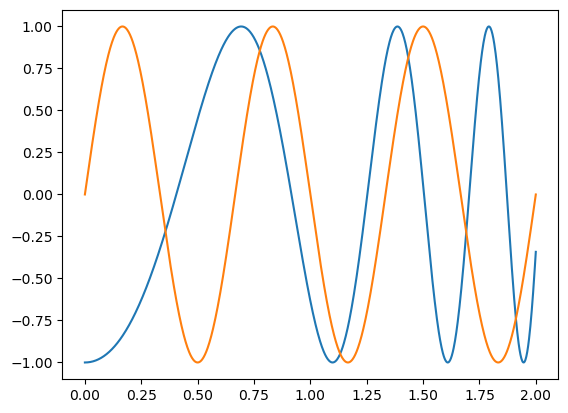

In [2]:
time = jnp.linspace(0, 2, 1000)

# x = jnp.array([jnp.sin(time*np.pi), jnp.cos(time*np.pi)]).T
# x = (jnp.array([time, jnp.sin(3.1*time*np.pi)]).T)[jnp.newaxis]
x = (jnp.array([time, jnp.cos(jnp.exp(time)*np.pi)]).T)[jnp.newaxis]
y = (jnp.array([time, jnp.sin(3*time*np.pi)]).T)[jnp.newaxis]
X = jnp.vstack([x, y])

print(X.shape)

plt.plot(X[0, :, 0], X[0, :, 1])
plt.plot(X[1, :, 0], X[1, :, 1])

Compute the neural Signature and the Gram Matrix

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:02<00:00,  7.41it/s]


[[46.964817 22.501085]
 [22.501085 21.673437]]


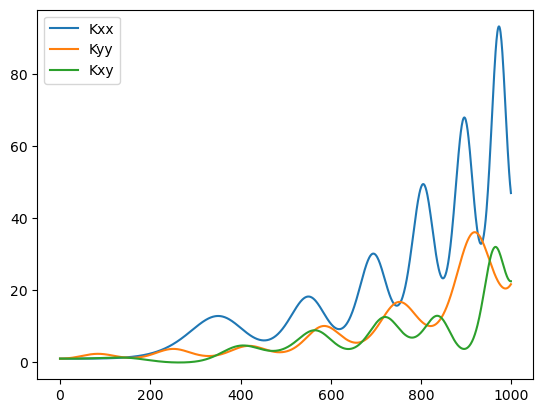

In [3]:
M, N, d = 20, 100, 2
activation = lambda x: x
 
norms = []
nSigs = []

for m in tqdm(range(M)):
  _, key = random.split(key)

  # key, S_0, AA, bb = sparsify_weights(*Weibull_weights(key, N, d))
  key, S_0, AA, bb = LogNormal_weights(key, N, d)

  model = nSig(S_0, AA, bb, activation)
  S = model.forward(X)/np.sqrt(N)

  norms.append(jnp.linalg.norm(S, axis=-1)**2)
  nSigs.append(S)

norms, nSigs = jnp.array(norms), jnp.array(nSigs)
Z = nSigs.swapaxes(1,2)
Gram = (Z@Z.swapaxes(-1,-2)).mean(axis=0)

plt.plot(Gram[:,0,0], label="Kxx")
plt.plot(Gram[:,1,1], label="Kyy")
plt.plot(Gram[:,0,1], label="Kxy")
plt.legend()

print(Gram[-1])

In [4]:
# Gram_full: (batch, batch, times, times)
Gram_full = model.Gram_precomputed(nSigs[0], nSigs[0])

print(Gram_full.shape)

(2, 2, 1000, 1000)


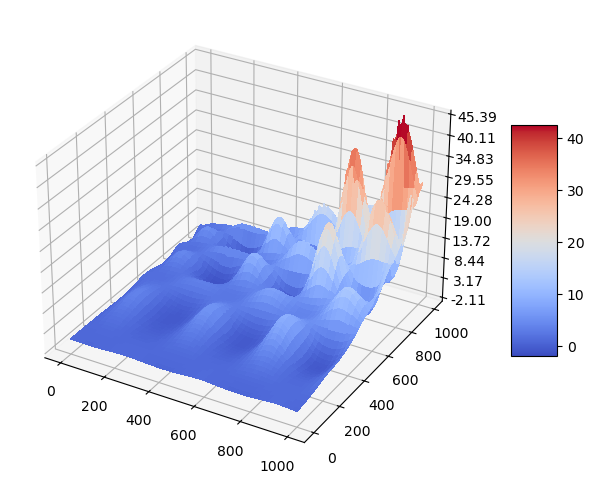

In [5]:
plot_Gram(Gram_full[0,1])

# SigKerax

In [7]:
from sigkerax.sigkernel import SigKernel

signature_kernel = SigKernel(refinement_factor=2, static_kernel_kind="linear", add_time=False)
signature_kernel_matrix = signature_kernel.kernel_matrix(X, X)

print(signature_kernel_matrix)

[[[53.50453 ]
  [25.376522]]

 [[25.376522]
  [24.11921 ]]]
